In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

data = pd.read_csv("LoanApprovalPrediction.csv") 


C:\Users\SANGAMESH DAVEY\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
data.head(5)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
obj = (data.dtypes == 'object') 
print("Categorical variables:",len(list(obj[obj].index)))


Categorical variables: 7


In [4]:
# Dropping Loan_ID column 
data.drop(['Loan_ID'],axis=1,inplace=True)


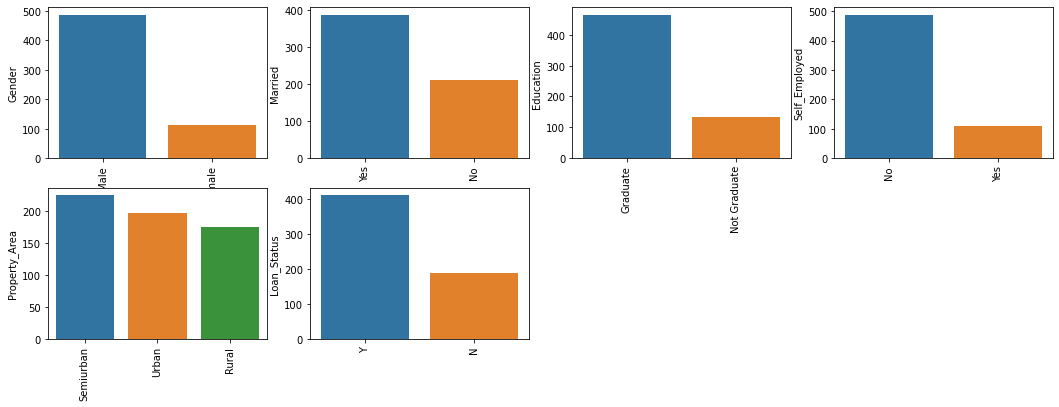

In [5]:
obj = (data.dtypes == 'object') 
object_cols = list(obj[obj].index) 
plt.figure(figsize=(18,36)) 
index = 1

for col in object_cols: 
    y = data[col].value_counts() 
    plt.subplot(11,4,index) 
    plt.xticks(rotation=90) 
    sns.barplot(x=list(y.index), y=y) 
    index +=1


In [6]:
# Import label encoder 
from sklearn import preprocessing 
	
# label_encoder object knows how 
# to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
obj = (data.dtypes == 'object') 
for col in list(obj[obj].index): 
    data[col] = label_encoder.fit_transform(data[col])


In [7]:
# To find the number of columns with 
# datatype==object 
obj = (data.dtypes == 'object') 
print("Categorical variables:",len(list(obj[obj].index)))


Categorical variables: 0


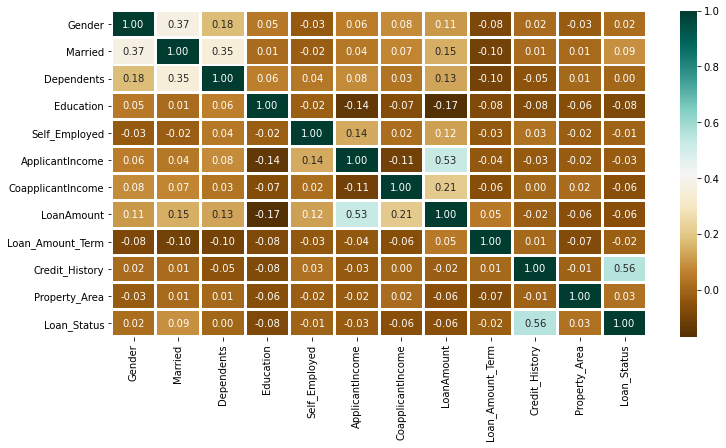

In [8]:
plt.figure(figsize=(12,6)) 

sns.heatmap(data.corr(),cmap='BrBG',fmt='.2f', 
			linewidths=2,annot=True)


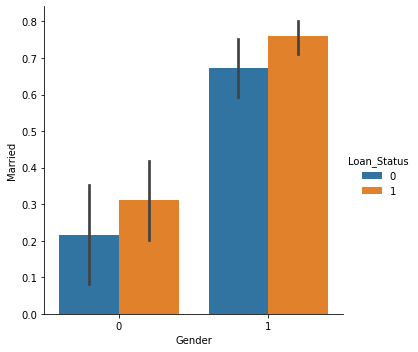

In [9]:
sns.catplot(x="Gender", y="Married", 
			hue="Loan_Status", 
			kind="bar", 
			data=data)


In [10]:
for col in data.columns: 
    data[col] = data[col].fillna(data[col].mean()) 
	
data.isna().sum()


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [11]:
from sklearn.model_selection import train_test_split 

X = data.drop(['Loan_Status'],axis=1) 
Y = data['Loan_Status'] 
X.shape,Y.shape 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
													test_size=0.4, 
													random_state=1) 
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((358, 11), (240, 11), (358,), (240,))

In [12]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression 

from sklearn import metrics 

knn = KNeighborsClassifier(n_neighbors=3) 
rfc = RandomForestClassifier(n_estimators = 7, 
							criterion = 'entropy', 
							random_state =7) 
svc = SVC() 
lc = LogisticRegression(max_iter=10000) 

# making predictions on the training set 
for clf in (rfc, knn, svc,lc): 
	clf.fit(X_train, Y_train) 
	Y_pred = clf.predict(X_train) 
	print("Accuracy score of ", 
		clf.__class__.__name__, 
		"=",100*metrics.accuracy_score(Y_train, 
										Y_pred))


Accuracy score of  RandomForestClassifier = 98.04469273743017
Accuracy score of  KNeighborsClassifier = 78.49162011173185
Accuracy score of  SVC = 68.71508379888269
Accuracy score of  LogisticRegression = 79.60893854748603


In [13]:
# making predictions on the testing set 
for clf in (rfc, knn, svc,lc): 
	clf.fit(X_train, Y_train) 
	Y_pred = clf.predict(X_test) 
	print("Accuracy score of ", 
		clf.__class__.__name__,"=", 
		100*metrics.accuracy_score(Y_test, 
									Y_pred))


Accuracy score of  RandomForestClassifier = 82.5
Accuracy score of  KNeighborsClassifier = 63.74999999999999
Accuracy score of  SVC = 69.16666666666667
Accuracy score of  LogisticRegression = 80.41666666666667


In [14]:
X_train.iloc[1]

Gender                  1.0
Married                 0.0
Dependents              0.0
Education               0.0
Self_Employed           0.0
ApplicantIncome      3069.0
CoapplicantIncome       0.0
LoanAmount             71.0
Loan_Amount_Term      480.0
Credit_History          1.0
Property_Area           2.0
Name: 370, dtype: float64

In [15]:
from joblib import dump

# Save the RFC model
dump(rfc, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [25]:
from sklearn.pipeline import Pipeline
from nyoka import skl_to_pmml

# Create a pipeline with the Random Forest Classifier
pipeline = Pipeline([('rfc', rfc_model)])

# Convert the pipeline to PMML format
skl_to_pmml(pipeline, list(X_train.columns), "random_forest_model.pmml")


In [22]:
!pip install nyoka


     -------------------------------------- 304.0/304.0 kB 4.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
from flask import Flask, jsonify, request
import joblib

app = Flask(__name__)

# Load the saved model
model = joblib.load('random_forest_model.pkl')
print("done")
@app.route('/predict', methods=['POST'])
def predict():
    # Get the input data from the request
    data = request.json
    feat=X_train.iloc[1]
    # Make prediction using the loaded model
    prediction = model.predict(feat)

    # Prepare the response
    response = {
        'prediction': prediction[0]  # Assuming prediction is a single value
    }

    return jsonify(response)

if __name__ == '__main__':
    app.run(debug=True)


done
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with windowsapi reloader


SystemExit: 1

In [47]:
X_train.iloc[3]

Gender                  1.0
Married                 1.0
Dependents              2.0
Education               0.0
Self_Employed           0.0
ApplicantIncome      2957.0
CoapplicantIncome       0.0
LoanAmount             81.0
Loan_Amount_Term      360.0
Credit_History          1.0
Property_Area           1.0
Name: 121, dtype: float64

In [48]:
list=[]
for i in range(11):
    list.append(X_train.iloc[3][i])

In [49]:
list

[1.0, 1.0, 2.0, 0.0, 0.0, 2957.0, 0.0, 81.0, 360.0, 1.0, 1.0]

In [46]:
Y_train.iloc[3]

1